In [1]:
import torch

import numpy as np

from torchdiffeq import odeint_adjoint as odeint

from torchfilter.util import safe_cast

from pdes.models import LandauCahnHilliard, FloryHugginsCahnHilliard

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use("ggplot")

In [2]:
device = torch.device('cpu')

dx, NX = 5e2, 256

ts = torch.arange(1e4, device=device)

In [3]:
LANDAU=False

In [4]:
pde = LandauCahnHilliard(
    params={'a':torch.tensor([6.07e-6,7.07e-6]), 'b':torch.tensor([1.2e-4]), 'k':torch.tensor([0.71])},
    M=1e8, dx=dx
) if LANDAU else FloryHugginsCahnHilliard(
    params={
        'Na':torch.tensor([1e5]),
        'Nb':torch.tensor([1e5]),
        'chi':torch.tensor([2.5e-5]),
        'k':torch.tensor([0.71])
    },
    M=1e8, dx=dx
)


In [5]:
phi0 = 0.2 * torch.rand((NX,NX), device=device).view(-1,1,NX,NX)
phis = odeint(pde, phi0 if LANDAU else phi0+0.5, ts, method='euler')

In [6]:
phis.shape

torch.Size([10000, 1, 1, 256, 256])

In [7]:
def complex_tensor(X):
    _X = X[...,None]
    return torch.cat([_X, torch.zeros_like(_X)], len(X.shape))
def conjugate(X):
    X[...,1] = -X[...,1]
    return X

def fftshift(X):
    dims  = X.shape
    nx, ny = dims[-3] // 2, dims[-2] // 2
    Y = torch.zeros_like(X)
    Y[..., 0:nx, 0:ny, :] = X[..., nx: , ny: , :]
    Y[..., 0:nx, ny: , :] = X[..., nx: , 0:ny, :]
    Y[..., nx: , ny: , :] = X[..., 0:nx, 0:ny, :]
    Y[..., nx: , 0:ny, :] = X[..., 0:nx, ny: , :]
    return Y

def scattering(phi, dx, calculate_q = False, device='cpu'):
    F = torch.fft(complex_tensor(phi), 2)
    F = fftshift(F)
    
    absF = torch.sqrt(F[..., 0]**2 + F[..., 1]**2)
    return radial_avg(absF, dx, calculate_q, device)

def radial_avg(X, dx, calculate_q = True, device='cpu'):
    device = safe_cast(torch.device, device)
    nx,ny = X.shape[-2:]
    xi, yi = np.indices((nx, ny))
    r = torch.tensor(
        np.sqrt((xi-0.5*nx)**2 + (yi-0.5*ny)**2).astype(np.int),
        device=device
    )
    if calculate_q:
        qsx = torch.linspace(-1/(2*dx), 1/(2*dx), nx)
        qsy = torch.linspace(-1/(2*dx), 1/(2*dx), ny)
        qr = torch.tensor(
            [[torch.sqrt((qx**2 + qy**2)) for qx in qsx] for qy in qsy],
            device=device
        )
        q = torch.bincount(r.view(-1), qr.view(-1)) / torch.bincount(r.view(-1))

    S = torch.stack(
        [torch.bincount(r.view(-1),X[i,...].view(-1))/torch.bincount(r.view(-1)) for i in range(X.shape[0])],
        0
    )
    return (q[1:],S[...,1:]) if calculate_q else S[...,1:]

In [8]:
t_ = ts[99::900]
phis_ = phis[99::900,:,0,...]
Ss = []

for i in range(len(t_)):
    if i > 0:
        S_ = scattering(phis_[i,...], dx)
    else:
        q, S_ = scattering(phis_[i,...], dx, True)
    Ss.append(S_)
    
Ss = torch.stack(Ss,0)

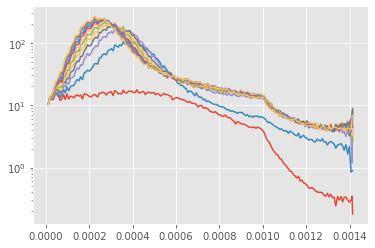

In [9]:
if Ss.shape[1] == 2:
    _, axs = plt.subplots(1,2,figsize=(14,6), sharey=True)
    for i,ax in enumerate(axs):
        ax.plot(torch.stack([q]*len(t_),0).transpose(1,0), Ss[:,i,:].transpose(1,0).detach(),'-')
        plt.yscale('log')
else:
    plt.plot(torch.stack([q]*len(t_),0).transpose(1,0), Ss[:,0,:].transpose(1,0).detach(),'-')
    plt.yscale('log')